# Предложение 3

Стимулировать короткие поездки в "богатых" зонах.

In [13]:
import clickhouse_connect
import json
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
from matplotlib import pyplot as plt

In [2]:
# Load config from file
with open('./dags/conf/config.json', 'r') as f:
    CONFIG = json.load(f)

# Load credentials
load_dotenv('./dags/conf/.env', override=True)

# TODO
CONFIG['clickhouse']['host'] = 'localhost'

db = CONFIG['clickhouse']['dbs']['golden_db']


In [3]:
# Create Clickhouse client
ch_client = clickhouse_connect.get_client(
    host=CONFIG['clickhouse']['host'],
    port=CONFIG['clickhouse']['port'],
    username=os.getenv('CLICKHOUSE_USER'),
    password=os.getenv('CLICKHOUSE_PASS')
)


In [4]:
# Estimate price elasticity short trips
# Get average fare and demand by date
sql = f"""
    WITH lim AS (
        SELECT max_distance
        FROM {db}.dim_distance
            WHERE lower(distance_bucket_name) = 'short'
        ORDER BY load_date DESC
        LIMIT 1
    )
    SELECT 
        ddt.`date`,
        ddt.`hour`,
        COUNT(*) AS trips_count,
        AVG(ft.total_amount) AS avg_fare
    FROM {db}.fact_trip ft
    CROSS JOIN lim
    JOIN {db}.dim_datetime ddt
        ON ft.pickup_datetime_id = ddt.datetime_id
    WHERE ft.trip_distance < lim.max_distance
    GROUP BY ddt.`date`, ddt.`hour`
"""

try:
    short_df = ch_client.query_df(sql)

except Exception as e:
    print(f'Error getting trips statistics: {e}')


In [5]:
print(short_df.head(10))

        date  hour  trips_count  avg_fare
0 2017-01-04     7         5706  7.146677
1 2017-02-24    17         8192  8.850626
2 2017-02-02     1         1626  7.092958
3 2017-02-22     9         7547  8.283105
4 2017-02-14     2          727  6.882449
5 2017-02-19    13         5881  7.439362
6 2017-02-11     6         1292  6.385774
7 2017-02-25    21         7203  8.308751
8 2017-01-30     5         1048  6.882185
9 2017-01-03     3          384  6.686901


In [6]:
# Log transformation for log-log Linear Regression
log_df = short_df.copy()
log_df['log_demand'] = np.log(log_df['trips_count'])
log_df['log_price'] = np.log(log_df['avg_fare'])
log_df = pd.get_dummies(log_df, columns=['hour'], dtype=float, drop_first=True)

In [7]:
log_df.dtypes

date           datetime64[ns]
trips_count            uint64
avg_fare              float64
log_demand            float64
log_price             float64
hour_1                float64
hour_2                float64
hour_3                float64
hour_4                float64
hour_5                float64
hour_6                float64
hour_7                float64
hour_8                float64
hour_9                float64
hour_10               float64
hour_11               float64
hour_12               float64
hour_13               float64
hour_14               float64
hour_15               float64
hour_16               float64
hour_17               float64
hour_18               float64
hour_19               float64
hour_20               float64
hour_21               float64
hour_22               float64
hour_23               float64
dtype: object

In [8]:
# Regression with hour fixed effects
X = log_df[['log_price'] + [c for c in log_df.columns if c.startswith('hour_')]]

X = sm.add_constant(X)
y = log_df['log_demand']

model = sm.OLS(y, X).fit()


In [9]:
# Modelig result
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             log_demand   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     303.3
Date:                Fri, 12 Dec 2025   Prob (F-statistic):               0.00
Time:                        16:18:09   Log-Likelihood:                -483.39
No. Observations:                1417   AIC:                             1017.
Df Residuals:                    1392   BIC:                             1148.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5392      0.321     -1.678      0.0

In [10]:
elasticity = model.params['log_price']
r2 = model.rsquared
print('\n\nElasticity:', elasticity, '\nR2:', r2)



Elasticity: 4.261922338023919 
R2: 0.8394789081749203


In [20]:
# Define scenarios for price changes
price_factors = np.linspace(0.7, 1.0, 4)
print(price_factors)


[0.7 0.8 0.9 1. ]


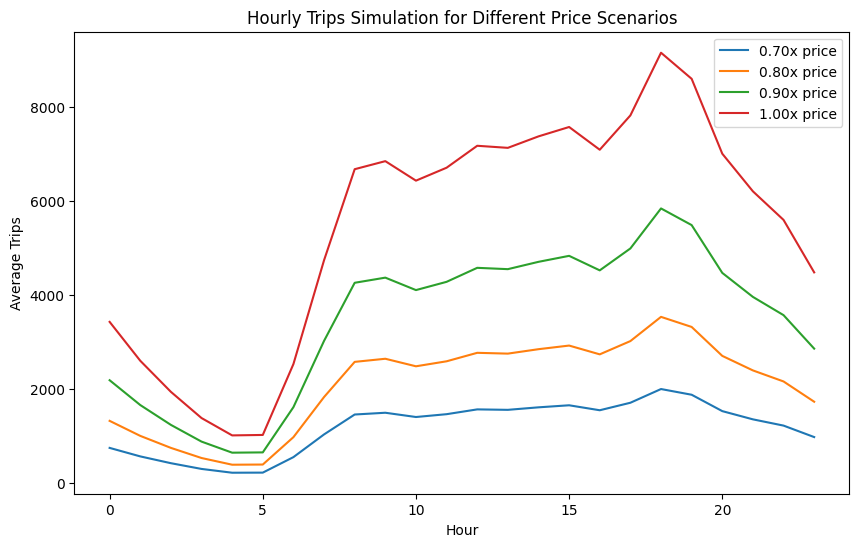

<Axes: title={'center': 'Total Revenue by Price Scenario'}, xlabel='Price Factor', ylabel='Total Revenue'>

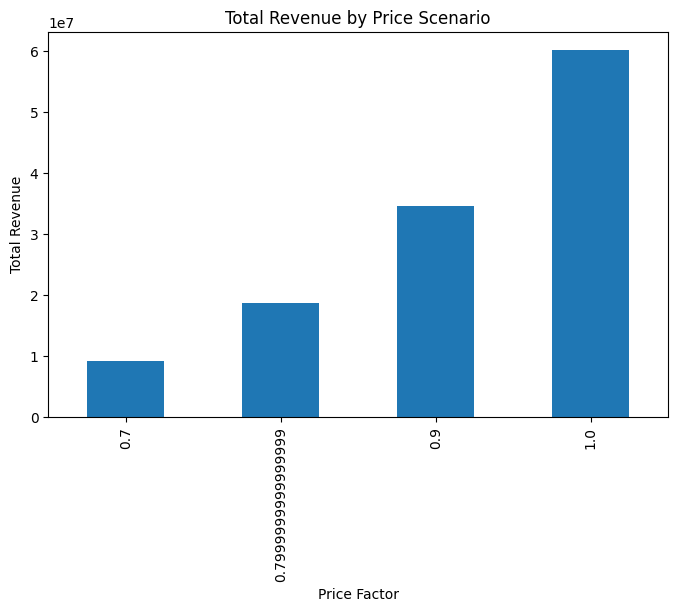

In [21]:
results = []
plt.figure(figsize=(10,6))

# Calculate trips and revenue changes for each scenario
for factor in price_factors:
    sim = short_df.copy()
    sim['price_new'] = sim['avg_fare'] * factor
    sim['trips_new'] = sim['trips_count'] * (factor) ** elasticity
    sim['revenue_new'] = sim['price_new'] * sim['trips_new']
    
    # New daily revenue
    daily_revenue = sim.groupby('date')['revenue_new'].sum().reset_index()
    results.append({'factor': factor, 'daily_revenue': daily_revenue})
    
    # New trips count by hour
    trips_by_hour = sim.groupby('hour')[['trips_new']].mean().reset_index()
    plt.plot(trips_by_hour['hour'], trips_by_hour['trips_new'], label=f'{factor:.2f}x price')

plt.xlabel('Hour')
plt.ylabel('Average Trips')
plt.title('Hourly Trips Simulation for Different Price Scenarios')
plt.legend()
plt.show()

# Total revenue for different scenarios
df_total = pd.DataFrame({
    'price_factor': [r['factor'] for r in results],
    'total_revenue': [r['daily_revenue']['revenue_new'].sum() for r in results]
})

df_total.plot(x='price_factor',
            y='total_revenue',
            kind='bar',
            figsize=(8,5),
            legend=False,
            ylabel='Total Revenue',
            xlabel='Price Factor',
            title='Total Revenue by Price Scenario')
